<a href="https://colab.research.google.com/github/RDGopal/Prompt-Engineering-Guide/blob/main/Lecture_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Learning with Text
In this session, we will demonstrate how to perform predictive modeling with text data. We will use the `sms_spam.csv` dataset to analyze and predict whether an SMS is spam or not. We will explore three different approaches to achieve this:
1.	Create word tokens and use TF-IDF values to capture the essence of the text, and use these to predict the outcome.
2. Compute sentiment of the text, and use the sentiment captured in the text to predict the outcome.
3.	Use topic modeling to identify k topics, and use the percentage of each topic captured in the text to predict the outcome.

In a later session, we will also explore using word embeddings for predictive purposes.


In [2]:
import pandas as pd
import re
import nltk

from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Read the file

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# upload files using file picker
from google.colab import files
files.upload()

In [39]:
df = pd.read_csv('sms_spam.csv')

In [8]:
df

,type,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts may...
3,ham,u dun say early hor u c already say
4,ham,nah think goes usf lives around though
...,...,...
5569,spam,time tried contact u pound prize claim easy ca...
5570,ham,b going esplanade fr home
5571,ham,pity mood suggestions
5572,ham,guy bitching acted like interested buying some...


## Preprocess

In [40]:
# Put it all into a function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Tokenize
    tokens = nltk.word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and token.isalpha()]
    return ' '.join(tokens)



In [41]:
df['text'] = df['text'].apply(preprocess_text)

In [ ]:
df

##TF-IDF
We will use the 100 most important terms, write them out to the file, and build a prediction model using random forest algorithm.

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare the data using the correct TF-IDF features
vectorizer_corrected = TfidfVectorizer(max_features=100)
tfidf_matrix_corrected = vectorizer_corrected.fit_transform(df['text'])
tfidf_df_corrected = pd.DataFrame(tfidf_matrix_corrected.toarray(), columns=vectorizer_corrected.get_feature_names_out())
df_corrected = pd.concat([df.drop(columns=['text']), tfidf_df_corrected], axis=1)  # Exclude original 'text' column for modeling

# Prepare the data for modeling
X_corrected = df_corrected.drop(columns=['type'])  # Features
y_corrected = df_corrected['type']  # Target

# Fill NaN values with zeros (common practice in TF-IDF where NaN signifies no occurrence of the term)
X_train_corrected = X_train_corrected.fillna(0)
X_test_corrected = X_test_corrected.fillna(0)

# Reinitialize and train the Random Forest classifier with the NaN-free data
rf_classifier_corrected.fit(X_train_corrected, y_train_corrected)

# Predict on the NaN-free test set
y_pred_corrected = rf_classifier_corrected.predict(X_test_corrected)

# Evaluate the model again
evaluation_report_corrected = classification_report(y_test_corrected, y_pred_corrected)

# Output the evaluation report
evaluation_report_corrected



'              precision    recall  f1-score   support\n\n         ham       0.97      0.98      0.98       954\n        spam       0.90      0.84      0.87       161\n\n    accuracy                           0.96      1115\n   macro avg       0.94      0.91      0.93      1115\nweighted avg       0.96      0.96      0.96      1115\n'

### Confusion Matrix

In [54]:
# Calculate and print the confusion matrix for the Random Forest model
conf_matrix_sent = confusion_matrix(y_test_corrected, y_pred_corrected)
conf_matrix_sent

array([[939,  15],
       [ 25, 136]])

### ROC

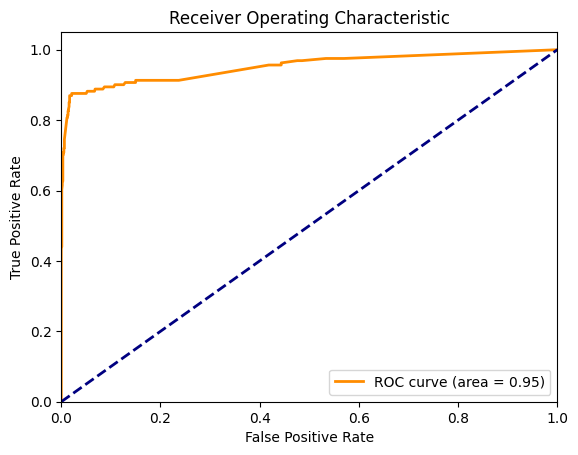

In [45]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

y_prob = rf_classifier_corrected.predict_proba(X_test_corrected)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_corrected, y_prob, pos_label='spam')
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Feature Importance

In [48]:
# Calculate feature importances and extract top 20
feature_importances = rf_classifier_corrected.feature_importances_
top_features = np.argsort(feature_importances)[-20:][::-1]  # Get indices of top 20 features
top_feature_names = vectorizer_corrected.get_feature_names_out()[top_features]
top_feature_scores = feature_importances[top_features]

# Compile feature importance information
top_20_features = pd.DataFrame({
    'Feature': top_feature_names,
    'Importance': top_feature_scores
})

In [ ]:
top_20_features

## VADER Sentiment
Compute VADER sentiment and write it to the data frame.

In [50]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download VADER lexicon if not already downloaded
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to get the compound sentiment score for each text
def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

# Apply the function to get sentiment score for each message in the DataFrame
df['vader_sentiment'] = df['text'].apply(get_sentiment)

# Display the first few rows to verify sentiment scores
df[['text', 'vader_sentiment']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,text,vader_sentiment
0,go jurong point crazy available bugis n great ...,0.4019
1,ok lar joking wif u oni,0.4767
2,free entry wkly comp win fa cup final tkts may...,0.7964
3,u dun say early hor u c already say,0.0000
4,nah think goes usf lives around though,-0.1027


### Prediction Model

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Example setup: Assume 'vader_sentiment' column exists in df
# Create sample sentiment data for demonstration (normally you would have real scores here)
import numpy as np
df['vader_sentiment'] = np.random.rand(df.shape[0])  # Random scores for illustration

# Prepare the data for modeling
X_sentiment = df[['vader_sentiment']]  # Predictor
y_sentiment = df['type']  # Target

# Split the data into training and test sets
X_train_sent, X_test_sent, y_train_sent, y_test_sent = train_test_split(X_sentiment, y_sentiment, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_sentiment_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_sentiment_classifier.fit(X_train_sent, y_train_sent)

# Predict on the test set
y_pred_sent = rf_sentiment_classifier.predict(X_test_sent)

# Evaluate the model
evaluation_report_sent = classification_report(y_test_sent, y_pred_sent)

# Output the evaluation report
evaluation_report_sent


'              precision    recall  f1-score   support\n\n         ham       0.85      0.88      0.86       954\n        spam       0.13      0.11      0.11       161\n\n    accuracy                           0.77      1115\n   macro avg       0.49      0.49      0.49      1115\nweighted avg       0.75      0.77      0.76      1115\n'

###Confusion Matrix

In [53]:
# Calculate and print the confusion matrix for the Random Forest model
conf_matrix_sent = confusion_matrix(y_test_sent, y_pred_sent)
conf_matrix_sent


array([[836, 118],
       [144,  17]])

### ROC

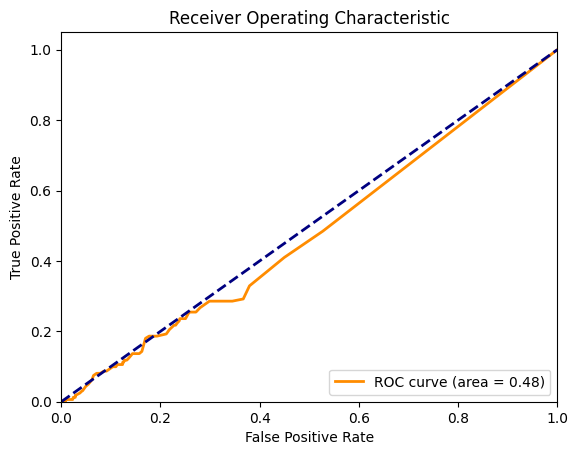

In [55]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Predict probabilities for the test set
y_prob_sent = rf_sentiment_classifier.predict_proba(X_test_sent)[:, 1]  # Probabilities for the positive class

# Calculate ROC curve and ROC AUC
fpr_sent, tpr_sent, _ = roc_curve(y_test_sent, y_prob_sent, pos_label='spam')
roc_auc_sent = auc(fpr_sent, tpr_sent)

# Plot ROC curve
plt.figure()
plt.plot(fpr_sent, tpr_sent, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_sent)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Topic Modeling
We use LDA to create 10 topics and write them out to the data frame.

In [58]:
import gensim
import gensim.corpora as corpora
from gensim.models.ldamodel import LdaModel

###LDA

In [60]:
# Assuming the text is preprocessed and stored as a list of words in df['text_preprocessed']
# If df['text'] is a single string of words, split it into lists
if isinstance(df['text'].iloc[0], str):
    df['text_preprocessed'] = df['text'].apply(lambda x: x.split())

# Create a Dictionary and Corpus from the preprocessed text
id2word_preprocessed = corpora.Dictionary(df['text_preprocessed'])
corpus_preprocessed = [id2word_preprocessed.doc2bow(text) for text in df['text_preprocessed']]

# Step 2: Initialize and fit the LDA model
lda_model_preprocessed = LdaModel(corpus=corpus_preprocessed, id2word=id2word_preprocessed, num_topics=10, random_state=42, update_every=1, passes=10, alpha='auto', per_word_topics=True)

# Step 3: Extract Topic Distributions
topic_distributions_preprocessed = [lda_model_preprocessed.get_document_topics(bow) for bow in corpus_preprocessed]

# Normalize topic distributions and ensure each document has distribution over all 10 topics
def normalize_topic_distributions(distributions, num_topics=10):
    normalized = []
    for dist in distributions:
        doc_topics = dict(dist)
        normalized.append([doc_topics.get(i, 0) for i in range(num_topics)])
    return normalized

# Normalize topic distributions
normalized_topics_preprocessed = normalize_topic_distributions(topic_distributions_preprocessed)

# Create DataFrame with topic distributions
topics_df_preprocessed = pd.DataFrame(normalized_topics_preprocessed, columns=[f"Topic{i+1}" for i in range(10)])

# Concatenate original DataFrame with topics DataFrame
df_with_topics_gensim_preprocessed = pd.concat([df, topics_df_preprocessed], axis=1)

# Display the DataFrame with topics
df_with_topics_gensim_preprocessed.head()


,type,text,vader_sentiment,text_preprocessed,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10
0,ham,go jurong point crazy available bugis n great ...,0.001477,"[go, jurong, point, crazy, available, bugis, n...",0.000000,0.000000,0.000000,0.000000,0.000000,0.648002,0.313113,0.000000,0.000000,0.000
1,ham,ok lar joking wif u oni,0.137265,"[ok, lar, joking, wif, u, oni]",0.014509,0.018814,0.010632,0.593157,0.013216,0.011514,0.308938,0.010747,0.000000,0.000
2,spam,free entry wkly comp win fa cup final tkts may...,0.922054,"[free, entry, wkly, comp, win, fa, cup, final,...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.963456,0.000
3,ham,u dun say early hor u c already say,0.009383,"[u, dun, say, early, hor, u, c, already, say]",0.010082,0.013072,0.000000,0.000000,0.000000,0.153807,0.779640,0.000000,0.000000,0.000
4,ham,nah think goes usf lives around though,0.596520,"[nah, think, goes, usf, lives, around, though]",0.012655,0.016398,0.000000,0.000000,0.198846,0.010043,0.011900,0.188470,0.000000,0.536


###Predict and Compute Performance Metrics

Confusion Matrix:
 [[934  20]
 [ 48 113]]


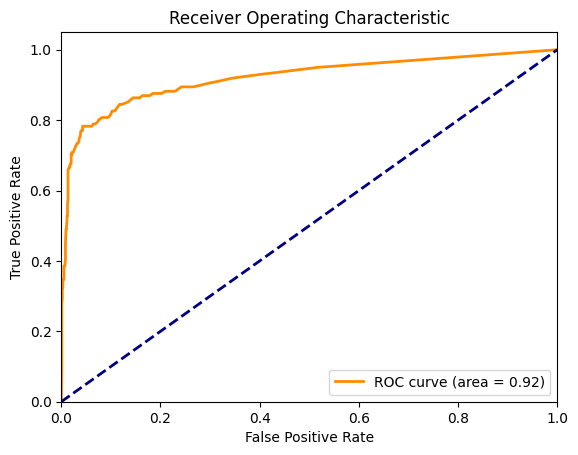

,Feature,Importance
1,Topic2,0.220804
8,Topic9,0.187389
0,Topic1,0.152894
6,Topic7,0.099744
4,Topic5,0.096845
5,Topic6,0.071946
2,Topic3,0.066992
3,Topic4,0.052372
7,Topic8,0.051014


In [61]:
# Prepare the data for modeling, excluding one topic for independence
X_topics_gensim_pp = df_with_topics_gensim_preprocessed[[f"Topic{i+1}" for i in range(9)]]  # Using Topic1 to Topic9
y_topics_gensim_pp = df_with_topics_gensim_preprocessed['type']  # Target variable

# Split the data into training and test sets
X_train_topics_gensim_pp, X_test_topics_gensim_pp, y_train_topics_gensim_pp, y_test_topics_gensim_pp = train_test_split(
    X_topics_gensim_pp, y_topics_gensim_pp, test_size=0.2, random_state=42
)

# Initialize and train the Random Forest classifier
rf_topics_gensim_pp_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_topics_gensim_pp_classifier.fit(X_train_topics_gensim_pp, y_train_topics_gensim_pp)

# Predict on the test set
y_pred_topics_gensim_pp = rf_topics_gensim_pp_classifier.predict(X_test_topics_gensim_pp)

# Calculate and print the confusion matrix
conf_matrix_topics_gensim_pp = confusion_matrix(y_test_topics_gensim_pp, y_pred_topics_gensim_pp)
print("Confusion Matrix:\n", conf_matrix_topics_gensim_pp)

# Calculate ROC curve and AUC if both classes are present in the test set
if len(np.unique(y_test_topics_gensim_pp)) > 1:
    y_prob_topics_gensim_pp = rf_topics_gensim_pp_classifier.predict_proba(X_test_topics_gensim_pp)[:, 1]
    fpr_topics_gensim_pp, tpr_topics_gensim_pp, _ = roc_curve(y_test_topics_gensim_pp, y_prob_topics_gensim_pp, pos_label='spam')
    roc_auc_topics_gensim_pp = auc(fpr_topics_gensim_pp, tpr_topics_gensim_pp)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr_topics_gensim_pp, tpr_topics_gensim_pp, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_topics_gensim_pp)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("ROC curve not plotted. The test set does not contain both classes.")

# Feature importances from the Random Forest model
feature_importances_topics_gensim_pp = pd.DataFrame({
    'Feature': X_topics_gensim_pp.columns,
    'Importance': rf_topics_gensim_pp_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

feature_importances_topics_gensim_pp
